## Введение в DS на УБ и МиРА (2022)
### Домашнее задание #5:  Ближайшие соседи
Дедлайн: 19 июня 2022 года, 23:59
Правила игры

Домашнее задание состоит из двух частей, которые оцениваются в 3 - 7 балла. Все пункты в пределах одной части имеют одинаковый вес.

Решения принимаются до 19 июня 2022 года, 23:59 МСК включительно. Работы, отправленные после дедлайна, не проверяются. Дата и время сдачи определяются по последнему запушенному в репозиторий коммиту (можно увидеть на GitHub, наведя мышкой на указатель срока (например, 3 days ago) справа от файлов).

Все решения нужно загрузить в личный репозиторий на GitHub Classroom.

Разрешается использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания. Разрешается использовать любые свободные источники с указанием ссылки на них.

Плагиат не допускается. При обнаружении случаев списывания, 
0
 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.


 ---

В этом задании будем предсказывать удовлетворенность студентов их программой (`LikeDegree`). Скачайте  Student_Behaviour.csv, содержащую информацию о студентов бакалавриата.


In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve
import itertools
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression

### Часть 1: Исследуем данные
**Задание 1.** Загрузите данные из файла Student_Behaviour.csv. Выведите первые 5 строк таблицы.

In [2]:
df = pd.read_csv('Student_Behaviour.csv')
df.head()

,CertificationCourses,Gender,Department,Height(CM),Weight(KG),10Mark,12Mark,CollegeMark,Hobbies,DailyStudingTime,PreferToStudyIn,SalaryExpectation,LikeDegree,CareerBasedonDegree,GamesSpendingTime,TravellingTime,StressLevel,FinancialStatus,PartTimeJob?
0,No,Male,BCA,100.0,58.0,79.0,65.0,80.0,Video Games,0 - 30 minute,Morning,40000,No,50%,1.30 - 2 hour,30 - 60 minutes,Bad,Bad,No
1,No,Female,BCA,90.0,40.0,70.0,80.0,70.0,Cinema,30 - 60 minute,Morning,15000,Yes,75%,1 - 1.30 hour,0 - 30 minutes,Bad,Bad,No
2,Yes,Male,BCA,159.0,78.0,69.5,61.0,55.0,Cinema,1 - 2 Hour,Anytime,13000,Yes,50%,More than 2 hour,30 - 60 minutes,Awful,Bad,No
3,Yes,Female,BCA,147.0,20.0,70.0,59.0,58.0,Reading books,1 - 2 Hour,Anytime,1500000,No,50%,1.30 - 2 hour,0 - 30 minutes,Bad,good,No
4,No,Male,BCA,170.0,54.0,40.0,65.0,30.0,Video Games,30 - 60 minute,Morning,50000,Yes,25%,1.30 - 2 hour,30 - 60 minutes,Good,good,No


**Задание 2.** Проверьте колонки на наличие пропусков, избавьтесь их. 

In [3]:
df.isna().sum()

CertificationCourses    0
Gender                  0
Department              0
Height(CM)              0
Weight(KG)              0
10Mark                  0
12Mark                  0
CollegeMark             0
Hobbies                 0
DailyStudingTime        0
PreferToStudyIn         0
SalaryExpectation       0
LikeDegree              0
CareerBasedonDegree     0
GamesSpendingTime       0
TravellingTime          0
StressLevel             0
FinancialStatus         0
PartTimeJob?            0
dtype: int64

In [4]:
df.describe()

,Height(CM),Weight(KG),10Mark,12Mark,CollegeMark,SalaryExpectation
count,235.000000,235.000000,235.000000,235.000000,235.000000,2.350000e+02
mean,157.402128,60.803830,76.842128,68.780128,70.660553,3.248168e+04
std,21.510805,14.895844,13.050800,11.016533,15.727446,1.113146e+05
min,4.500000,20.000000,7.400000,45.000000,1.000000,0.000000e+00
25%,152.000000,50.000000,70.000000,60.000000,60.000000,1.500000e+04
50%,160.000000,60.000000,80.000000,69.000000,70.000000,2.000000e+04
75%,170.000000,70.000000,86.250000,76.000000,80.000000,2.500000e+04
max,192.000000,106.000000,98.000000,94.000000,100.000000,1.500000e+06


**Задание 3.**  Колонку `CareerBasedonDegree` приведите к числовому виду.

In [5]:
df['CareerBasedonDegree'] = df['CareerBasedonDegree'].str.replace('%', '').astype('int64')

In [6]:
df.CareerBasedonDegree

0      50
1      75
2      50
3      50
4      25
       ..
230    50
231    75
232    50
233    75
234    75
Name: CareerBasedonDegree, Length: 235, dtype: int64

**Задание 4.**  В датасете есть 3 поля, с суффиксом `Time`, данные в них строковые, которые означают временной интервал. Извлеките минимальное время(левую границу интервала) для каждой из этих переменных и переведите в минуты, запишите в новые столбцы, удалите старые.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235 entries, 0 to 234
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CertificationCourses  235 non-null    object 
 1   Gender                235 non-null    object 
 2   Department            235 non-null    object 
 3   Height(CM)            235 non-null    float64
 4   Weight(KG)            235 non-null    float64
 5   10Mark                235 non-null    float64
 6   12Mark                235 non-null    float64
 7   CollegeMark           235 non-null    float64
 8   Hobbies               235 non-null    object 
 9   DailyStudingTime      235 non-null    object 
 10  PreferToStudyIn       235 non-null    object 
 11  SalaryExpectation     235 non-null    int64  
 12  LikeDegree            235 non-null    object 
 13  CareerBasedonDegree   235 non-null    int64  
 14  GamesSpendingTime     235 non-null    object 
 15  TravellingTime        2

Сделаем так, посмотрим на все значения, а потом приведем к минутам каждое по отдельности 

In [8]:
df.columns = df.columns.str.replace(' ', '') 

In [9]:
df['DailyStudingTime'].explode().value_counts() 

30 - 60 minute      81
1 - 2 Hour          61
0 - 30 minute       46
2 - 3 hour          24
3 - 4 hour          15
More Than 4 hour     8
Name: DailyStudingTime, dtype: int64

In [10]:
new = {'30 - 60 minute': '30', '1 - 2 Hour': '60', 
       '0 - 30 minute': '0', '2 - 3 hour': '120', 
       '3 - 4 hour': '180', 'More Than 4 hour': '240'}

In [11]:
df["DailyStudingTime"] = df["DailyStudingTime"].map(new).astype(float)

In [12]:
df['GamesSpendingTime'].explode().value_counts() 

30 - 60 Minute      69
1 - 1.30 hour       55
1 - 30 Minute       47
More than 2 hour    32
1.30 - 2 hour       27
0 Minute             5
Name: GamesSpendingTime, dtype: int64

In [13]:
new = {'30 - 60 Minute': '30', '1 - 1.30 hour': '60', 
       '1 - 30 Minute': '1','More than 2 hour': '120', 
       '1.30 - 2 hour': '90', '0 Minute': '0'}

In [14]:
df["GamesSpendingTime"] = df["GamesSpendingTime"].map(new).astype(float)

In [15]:
df['TravellingTime'].explode().value_counts() 

30 - 60 minutes     80
0 - 30 minutes      55
1 - 1.30 hour       51
1.30 - 2 hour       18
2 - 2.30 hour       14
more than 3 hour    10
2.30 - 3 hour        7
Name: TravellingTime, dtype: int64

In [16]:
new = {'30 - 60 minutes': '30', '0 - 30 minutes': '0', 
       '1 - 1.30 hour': '60', '1.30 - 2 hour': '90', 
       '2 - 2.30 hour': '120', 'more than 3 hour': '180',
       '2.30 - 3 hour': '150'}

In [17]:
df["TravellingTime"] = df["TravellingTime"].map(new).astype(float)

In [18]:
df

,CertificationCourses,Gender,Department,Height(CM),Weight(KG),10Mark,12Mark,CollegeMark,Hobbies,DailyStudingTime,PreferToStudyIn,SalaryExpectation,LikeDegree,CareerBasedonDegree,GamesSpendingTime,TravellingTime,StressLevel,FinancialStatus,PartTimeJob?
0,No,Male,BCA,100.0,58.0,79.0,65.0,80.0,Video Games,0.0,Morning,40000,No,50,90.0,30.0,Bad,Bad,No
1,No,Female,BCA,90.0,40.0,70.0,80.0,70.0,Cinema,30.0,Morning,15000,Yes,75,60.0,0.0,Bad,Bad,No
2,Yes,Male,BCA,159.0,78.0,69.5,61.0,55.0,Cinema,60.0,Anytime,13000,Yes,50,120.0,30.0,Awful,Bad,No
3,Yes,Female,BCA,147.0,20.0,70.0,59.0,58.0,Reading books,60.0,Anytime,1500000,No,50,90.0,0.0,Bad,good,No
4,No,Male,BCA,170.0,54.0,40.0,65.0,30.0,Video Games,30.0,Morning,50000,Yes,25,90.0,30.0,Good,good,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,Yes,Male,B.com ISM,170.0,76.0,72.0,67.0,65.0,Video Games,30.0,Morning,7000,Yes,50,120.0,30.0,Bad,Bad,No
231,Yes,Male,B.com ISM,172.0,52.0,72.0,70.0,76.0,Cinema,120.0,Anytime,25000,Yes,75,30.0,30.0,Good,good,No
232,Yes,Female,BCA,139.0,33.0,90.0,75.0,70.0,Cinema,30.0,Night,20000,Yes,50,30.0,150.0,Bad,good,No
233,Yes,Female,Commerce,153.0,58.0,85.0,74.0,75.0,Cinema,0.0,Anytime,20000,Yes,75,120.0,150.0,Awful,good,No


Отлично

**Задание 5.**  Выбрете колонки (непрерывные переменные), которые будете использовать для предсказания целевой переменной с помощью knn

Насколько понятно, непрерывные == числовые

In [19]:
df.describe()

,Height(CM),Weight(KG),10Mark,12Mark,CollegeMark,DailyStudingTime,SalaryExpectation,CareerBasedonDegree,GamesSpendingTime,TravellingTime
count,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,2.350000e+02,235.000000,235.000000,235.000000
mean,157.402128,60.803830,76.842128,68.780128,70.660553,57.829787,3.248168e+04,69.574468,49.731915,49.404255
std,21.510805,14.895844,13.050800,11.016533,15.727446,58.433730,1.113146e+05,21.178671,39.137611,46.726911
min,4.500000,20.000000,7.400000,45.000000,1.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,152.000000,50.000000,70.000000,60.000000,60.000000,30.000000,1.500000e+04,50.000000,30.000000,30.000000
50%,160.000000,60.000000,80.000000,69.000000,70.000000,30.000000,2.000000e+04,75.000000,30.000000,30.000000
75%,170.000000,70.000000,86.250000,76.000000,80.000000,60.000000,2.500000e+04,75.000000,75.000000,60.000000
max,192.000000,106.000000,98.000000,94.000000,100.000000,240.000000,1.500000e+06,100.000000,120.000000,180.000000


In [20]:
newdf = df.select_dtypes(include=np.number)

In [21]:
newdf

,Height(CM),Weight(KG),10Mark,12Mark,CollegeMark,DailyStudingTime,SalaryExpectation,CareerBasedonDegree,GamesSpendingTime,TravellingTime
0,100.0,58.0,79.0,65.0,80.0,0.0,40000,50,90.0,30.0
1,90.0,40.0,70.0,80.0,70.0,30.0,15000,75,60.0,0.0
2,159.0,78.0,69.5,61.0,55.0,60.0,13000,50,120.0,30.0
3,147.0,20.0,70.0,59.0,58.0,60.0,1500000,50,90.0,0.0
4,170.0,54.0,40.0,65.0,30.0,30.0,50000,25,90.0,30.0
...,...,...,...,...,...,...,...,...,...,...
230,170.0,76.0,72.0,67.0,65.0,30.0,7000,50,120.0,30.0
231,172.0,52.0,72.0,70.0,76.0,120.0,25000,75,30.0,30.0
232,139.0,33.0,90.0,75.0,70.0,30.0,20000,50,30.0,150.0
233,153.0,58.0,85.0,74.0,75.0,0.0,20000,75,120.0,150.0


**Задание 6.**  Есть ли в выбранных колонках выбросы? (Пока не нужно их чистить)

In [22]:
# https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-a-pandas-dataframe
newdf[(np.abs(stats.zscore(newdf)) < 3).all(axis=1)]

,Height(CM),Weight(KG),10Mark,12Mark,CollegeMark,DailyStudingTime,SalaryExpectation,CareerBasedonDegree,GamesSpendingTime,TravellingTime
0,100.0,58.0,79.0,65.00,80.0,0.0,40000,50,90.0,30.0
2,159.0,78.0,69.5,61.00,55.0,60.0,13000,50,120.0,30.0
4,170.0,54.0,40.0,65.00,30.0,30.0,50000,25,90.0,30.0
5,139.0,33.0,90.0,75.00,70.0,30.0,20000,50,30.0,0.0
7,152.0,43.0,61.6,61.67,75.0,60.0,25000,50,60.0,60.0
...,...,...,...,...,...,...,...,...,...,...
230,170.0,76.0,72.0,67.00,65.0,30.0,7000,50,120.0,30.0
231,172.0,52.0,72.0,70.00,76.0,120.0,25000,75,30.0,30.0
232,139.0,33.0,90.0,75.00,70.0,30.0,20000,50,30.0,150.0
233,153.0,58.0,85.0,74.00,75.0,0.0,20000,75,120.0,150.0


размер датасета уменьшился на 22, то есть столько выбросов по квантилю 99

**Задание 7.**  Как распределена целевая переменная? Нет ли дисбаланса классов? Если есть дисбаланс, какие метрики качества классификатора можно использовать, какие нет? Рассматриваем метрики, которые проходили в рамках курса.

<AxesSubplot:>

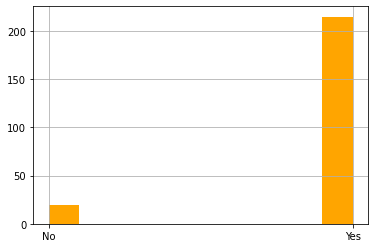

In [23]:
df.LikeDegree.hist(histtype='bar', color='orange')

Как проходили на курсе https://github.com/V-Marco/public_intro_to_DS_mba_hse/blob/main/seminars/week12%20-%20knn/sem12_classification.ipynb есть разные метрики которые можно использовать при неравных по количеству классах, как у нас
precision, recall итд(там написано)

**Задание 8.**  Переведите целевую переменную к численному формату.

In [24]:
df["LikeDegree"] = df["LikeDegree"].map({'Yes': '1', 'No': '0'}).astype(float)

In [25]:
df.LikeDegree

0      0.0
1      1.0
2      1.0
3      0.0
4      1.0
      ... 
230    1.0
231    1.0
232    1.0
233    1.0
234    0.0
Name: LikeDegree, Length: 235, dtype: float64

### Часть 2: Строим модели
**Задание 1.** Разбейте выборку на обучающую и тестовую. 

In [26]:
target = df["LikeDegree"]
X = newdf

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.2, random_state=21)

**Задание 2.** Постройте наивную модель предсказания для целевой переменной. Наивная модель - это самая простая модель, без сложных зависимостей. Например, для регрессии наивная модель - среднее для целевой переменной (см. семинар 11). В данном случае наивной моделью может быть предположение "все студенты (не)довольны".

In [28]:
model = DummyClassifier(strategy='most_frequent')
model.fit(X, target)
y_pred = model.predict(X)

Заранее создадим таблицу со всеми метриками, так как они идут далее и можно было удобнее сравнивать

In [29]:
metrics_our = pd.DataFrame(index=['наивная', 'nn3', 'nn5', 'nn7',
                                 'nn3_norm', 'nn5_norm', 'nn7_norm',
                                 'nn3_mm','nn5_mm','nn7_mm'],
                      columns=['Accuracy', 'Precision', 'Recall'])

In [30]:
metrics_our.iloc[0, 0] = metrics.accuracy_score(target, y_pred)
metrics_our.iloc[0, 1] = metrics.precision_score(target, y_pred)
metrics_our.iloc[0, 2] = metrics.recall_score(target, y_pred)

**Задание 3.** Постройте модели ближайших соседей для 3, 5, 7 ближайших соседей. 

In [31]:
n_3 = KNeighborsClassifier(n_neighbors=3)
n_3.fit(X_train, y_train)
pred = n_3.predict(X_test)

In [32]:
metrics_our.iloc[1, 0] = metrics.accuracy_score(y_test, pred)
metrics_our.iloc[1, 1] = metrics.precision_score(y_test, pred)
metrics_our.iloc[1, 2] = metrics.recall_score(y_test, pred)

In [33]:
n_5 = KNeighborsClassifier(n_neighbors=5)
n_5.fit(X_train, y_train)
pred = n_5.predict(X_test)

In [34]:
metrics_our.iloc[2, 0] = metrics.accuracy_score(y_test, pred)
metrics_our.iloc[2, 1] = metrics.precision_score(y_test, pred)
metrics_our.iloc[2, 2] = metrics.recall_score(y_test, pred)

In [35]:
n_7 = KNeighborsClassifier(n_neighbors=7)
n_7.fit(X_train, y_train)
pred = n_7.predict(X_test)

In [36]:
metrics_our.iloc[3, 0] = metrics.accuracy_score(y_test, pred)
metrics_our.iloc[3, 1] = metrics.precision_score(y_test, pred)
metrics_our.iloc[3, 2] = metrics.recall_score(y_test, pred)

**Задание 4.** Постройте метрики качества на тестовой выборке (3 известных вам) для моделей из 1 и 2 задания и сравните между собой. Какая победила? 

In [37]:
metrics_our.astype('float').round(4)

,Accuracy,Precision,Recall
наивная,0.9149,0.9149,1.0
nn3,0.9362,0.9362,1.0
nn5,0.9362,0.9362,1.0
nn7,0.9362,0.9362,1.0
nn3_norm,NaN,NaN,NaN
nn5_norm,NaN,NaN,NaN
nn7_norm,NaN,NaN,NaN
nn3_mm,NaN,NaN,NaN
nn5_mm,NaN,NaN,NaN
nn7_mm,NaN,NaN,NaN


Пока победитель неясен... 

**Задание 5.** Примените шкалирование (MinMax, обучите его на обучающей выборке к факторам, затем примените к тестовой), снова постройте модели для нескольких вариантов соседей (3, 5, 7). Помогло ли шкалирование? 

In [38]:
scaler = MinMaxScaler( )
scaler.fit(X_train) 
train_norm = scaler.transform(X_train) 
test_norm = scaler.transform(X_test)

In [39]:
n_3 = KNeighborsClassifier(n_neighbors=3)
n_3.fit(train_norm, y_train)
pred = n_3.predict(test_norm)

In [40]:
metrics_our.iloc[4, 0] = metrics.accuracy_score(y_test, pred)
metrics_our.iloc[4, 1] = metrics.precision_score(y_test, pred)
metrics_our.iloc[4, 2] = metrics.recall_score(y_test, pred)

In [41]:
n_5 = KNeighborsClassifier(n_neighbors=5)
n_5.fit(train_norm, y_train)
pred = n_5.predict(test_norm)

In [42]:
metrics_our.iloc[5, 0] = metrics.accuracy_score(y_test, pred)
metrics_our.iloc[5, 1] = metrics.precision_score(y_test, pred)
metrics_our.iloc[5, 2] = metrics.recall_score(y_test, pred)

In [43]:
n_7 = KNeighborsClassifier(n_neighbors=7)
n_7.fit(train_norm, y_train)
pred = n_7.predict(test_norm)

In [44]:
metrics_our.iloc[6, 0] = metrics.accuracy_score(y_test, pred)
metrics_our.iloc[6, 1] = metrics.precision_score(y_test, pred)
metrics_our.iloc[6, 2] = metrics.recall_score(y_test, pred)

In [45]:
metrics_our.astype('float').round(4)

,Accuracy,Precision,Recall
наивная,0.9149,0.9149,1.0000
nn3,0.9362,0.9362,1.0000
nn5,0.9362,0.9362,1.0000
nn7,0.9362,0.9362,1.0000
nn3_norm,0.9149,0.9348,0.9773
nn5_norm,0.9362,0.9362,1.0000
nn7_norm,0.9362,0.9362,1.0000
nn3_mm,NaN,NaN,NaN
nn5_mm,NaN,NaN,NaN
nn7_mm,NaN,NaN,NaN


особо не помогло...

**Задание 6.** Избавьтесь от выбросов в исходной выборке, затем снова разделите ее на тестовую и обучающую, постройте модель для нескольких вариантов числа соседей(3, 5, 7). Какое число соседей лучшее и почему? Улучшилось ли качество модели по сравнению со лучшей моделью, в которой было применено шкалирование из задания 5?

In [143]:
newdf

,Height(CM),Weight(KG),10Mark,12Mark,CollegeMark,DailyStudingTime,SalaryExpectation,CareerBasedonDegree,GamesSpendingTime,TravellingTime
0,100.0,58.0,79.0,65.0,80.0,0.0,40000,50,90.0,30.0
1,90.0,40.0,70.0,80.0,70.0,30.0,15000,75,60.0,0.0
2,159.0,78.0,69.5,61.0,55.0,60.0,13000,50,120.0,30.0
3,147.0,20.0,70.0,59.0,58.0,60.0,1500000,50,90.0,0.0
4,170.0,54.0,40.0,65.0,30.0,30.0,50000,25,90.0,30.0
...,...,...,...,...,...,...,...,...,...,...
230,170.0,76.0,72.0,67.0,65.0,30.0,7000,50,120.0,30.0
231,172.0,52.0,72.0,70.0,76.0,120.0,25000,75,30.0,30.0
232,139.0,33.0,90.0,75.0,70.0,30.0,20000,50,30.0,150.0
233,153.0,58.0,85.0,74.0,75.0,0.0,20000,75,120.0,150.0


In [187]:
new1 = pd.concat([df['LikeDegree'], newdf], axis=1)

In [188]:
f = ['Height(CM)', 'Weight(KG)', '10Mark', '12Mark', 
           'CollegeMark', 'DailyStudingTime', 'SalaryExpectation',
           'CareerBasedonDegree', 'GamesSpendingTime', 'TravellingTime']

In [189]:
new1 = new1[(np.abs(stats.zscore(new1[f])) < 3).all(axis=1)]

In [190]:
new1

,LikeDegree,Height(CM),Weight(KG),10Mark,12Mark,CollegeMark,DailyStudingTime,SalaryExpectation,CareerBasedonDegree,GamesSpendingTime,TravellingTime
0,0.0,100.0,58.0,79.0,65.00,80.0,0.0,40000,50,90.0,30.0
2,1.0,159.0,78.0,69.5,61.00,55.0,60.0,13000,50,120.0,30.0
4,1.0,170.0,54.0,40.0,65.00,30.0,30.0,50000,25,90.0,30.0
5,1.0,139.0,33.0,90.0,75.00,70.0,30.0,20000,50,30.0,0.0
7,1.0,152.0,43.0,61.6,61.67,75.0,60.0,25000,50,60.0,60.0
...,...,...,...,...,...,...,...,...,...,...,...
230,1.0,170.0,76.0,72.0,67.00,65.0,30.0,7000,50,120.0,30.0
231,1.0,172.0,52.0,72.0,70.00,76.0,120.0,25000,75,30.0,30.0
232,1.0,139.0,33.0,90.0,75.00,70.0,30.0,20000,50,30.0,150.0
233,1.0,153.0,58.0,85.0,74.00,75.0,0.0,20000,75,120.0,150.0


Теперь осталось 213 из 235

In [191]:
target = new1["LikeDegree"]
X = new1.drop('LikeDegree', axis = 1)

In [192]:
target

0      0.0
2      1.0
4      1.0
5      1.0
7      1.0
      ... 
230    1.0
231    1.0
232    1.0
233    1.0
234    0.0
Name: LikeDegree, Length: 213, dtype: float64

<AxesSubplot:>

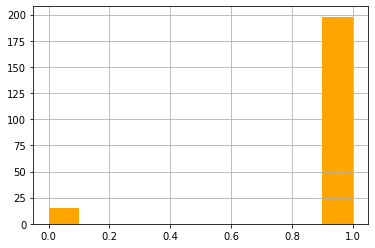

In [193]:
new1.LikeDegree.hist(histtype='bar', color='orange')

In [194]:
X

,Height(CM),Weight(KG),10Mark,12Mark,CollegeMark,DailyStudingTime,SalaryExpectation,CareerBasedonDegree,GamesSpendingTime,TravellingTime
0,100.0,58.0,79.0,65.00,80.0,0.0,40000,50,90.0,30.0
2,159.0,78.0,69.5,61.00,55.0,60.0,13000,50,120.0,30.0
4,170.0,54.0,40.0,65.00,30.0,30.0,50000,25,90.0,30.0
5,139.0,33.0,90.0,75.00,70.0,30.0,20000,50,30.0,0.0
7,152.0,43.0,61.6,61.67,75.0,60.0,25000,50,60.0,60.0
...,...,...,...,...,...,...,...,...,...,...
230,170.0,76.0,72.0,67.00,65.0,30.0,7000,50,120.0,30.0
231,172.0,52.0,72.0,70.00,76.0,120.0,25000,75,30.0,30.0
232,139.0,33.0,90.0,75.00,70.0,30.0,20000,50,30.0,150.0
233,153.0,58.0,85.0,74.00,75.0,0.0,20000,75,120.0,150.0


In [205]:
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.3, random_state=0)

In [206]:
n_3 = KNeighborsClassifier(n_neighbors=3)
n_3.fit(X_train, y_train)
pred = n_3.predict(X_test)

In [207]:
pred

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [208]:
metrics_our.iloc[7, 0] = metrics.accuracy_score(y_test, pred)
metrics_our.iloc[7, 1] = metrics.precision_score(y_test, pred)
metrics_our.iloc[7, 2] = metrics.recall_score(y_test, pred)

In [209]:
n_5 = KNeighborsClassifier(n_neighbors=5)
n_5.fit(X_train, y_train)
pred = n_5.predict(X_test)

In [210]:
metrics_our.iloc[8, 0] = metrics.accuracy_score(y_test, pred)
metrics_our.iloc[8, 1] = metrics.precision_score(y_test, pred)
metrics_our.iloc[8, 2] = metrics.recall_score(y_test, pred)

In [211]:
n_7 = KNeighborsClassifier(n_neighbors = 7)
n_7.fit(X_train, y_train)
pred = n_7.predict(X_test)

In [212]:
metrics_our.iloc[9, 0] = metrics.accuracy_score(y_test, pred)
metrics_our.iloc[9, 1] = metrics.precision_score(y_test, pred)
metrics_our.iloc[9, 2] = metrics.recall_score(y_test, pred)

In [213]:
metrics_our.astype('float').round(4)

,Accuracy,Precision,Recall
наивная,0.9149,0.9149,1.0000
nn3,0.9362,0.9362,1.0000
nn5,0.9362,0.9362,1.0000
nn7,0.9362,0.9362,1.0000
nn3_norm,0.9149,0.9348,0.9773
nn5_norm,0.9362,0.9362,1.0000
nn7_norm,0.9362,0.9362,1.0000
nn3_mm,0.8750,0.8889,0.9825
nn5_mm,0.8906,0.8906,1.0000
nn7_mm,0.8906,0.8906,1.0000


**Задание 7.** Какая конфигурация модели получилась лучшей? Почему?Выбираем из всех построенных моделей, не забудьте про наивный прогноз и все рассмотренне варианты числа соседей. 

In [214]:
metrics_our.astype('float').round(4)

,Accuracy,Precision,Recall
наивная,0.9149,0.9149,1.0000
nn3,0.9362,0.9362,1.0000
nn5,0.9362,0.9362,1.0000
nn7,0.9362,0.9362,1.0000
nn3_norm,0.9149,0.9348,0.9773
nn5_norm,0.9362,0.9362,1.0000
nn7_norm,0.9362,0.9362,1.0000
nn3_mm,0.8750,0.8889,0.9825
nn5_mm,0.8906,0.8906,1.0000
nn7_mm,0.8906,0.8906,1.0000


По идее очистка данных от выбросов всегда улучшает кнн, но у нас не так много значений в целом и тут есть небольшой рандом в соотношение значений внутри класса целевой переменной значения recall = 1, говорит, что он обнаруживает все классы, accuracy - точность ответов. Еще можно поиграться с кол-во split на тесты и трейны, тоже влияет на качество, так как опять же, данных всего 213.
В таблице видно, что победила модель с minmax для knn5/7 по всем метрикам, и что прикольно, наивная модель - совсем неплоха! но на самом деле нужно больше данных и тогда уже получится быть более объективными